# Artificial Neural Networks and Deep Learning

---

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [ ]:
data = np.load("cleaned_training_set.npz")

X_train = data["images"]
y_train = data["labels"]

data = np.load("mars_for_students.npz")

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 60

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5



In [ ]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
# train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#     X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
# )
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
#print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 2205
Validation: 300


In [ ]:
import tensorflow as tf

def make_dataset(images, labels, batch_size, shuffle=False, seed=None):
    """
    Create a TensorFlow dataset with augmentation by flipping images left-right, up-down, and combinations.

    Args:
        images: A NumPy array or Tensor containing the image data.
        labels: A NumPy array or Tensor containing the labels.
        batch_size: The size of batches for the dataset.
        shuffle: Whether to shuffle the dataset.
        seed: Random seed for reproducibility.

    Returns:
        A preprocessed and augmented TensorFlow dataset.
    """
    # Create a TensorFlow dataset from images and labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), seed=seed)

    def preprocess(image, label):
        # Ensure image and label are in float32 and grayscale images have correct shape
        image = tf.image.convert_image_dtype(image, tf.float32)
        if len(image.shape) == 2:
            image = tf.expand_dims(image, -1)
        if len(label.shape) == 2:
            label = tf.expand_dims(label, -1)
        return image, label

    def augment_dataset(ds):
        # Flip images left-to-right
        left_right_ds = ds.map(
            lambda img, lbl: (tf.image.flip_left_right(img), tf.image.flip_left_right(lbl)),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        # Flip images up-down
        up_down_ds = ds.map(
            lambda img, lbl: (tf.image.flip_up_down(img), tf.image.flip_up_down(lbl)),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        # Flip images both ways
        left_right_up_down_ds = left_right_ds.map(
            lambda img, lbl: (tf.image.flip_up_down(img), tf.image.flip_up_down(lbl)),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        # Concatenate all augmented datasets
        return ds.concatenate(left_right_ds).concatenate(up_down_ds).concatenate(left_right_up_down_ds)

    # Apply preprocessing
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Augment dataset
    dataset = augment_dataset(dataset)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")


Datasets created!


Counter({1.0: 6115087, 0.0: 4397248, 2.0: 4288104, 3.0: 3237214, 4.0: 25707})
{0.0: 0.24343466553287982, 3.0: 0.17921438757794786, 2.0: 0.2373923788265306, 1.0: 0.33853541090915534, 4.0: 0.0014231571534863946}
[4.0]


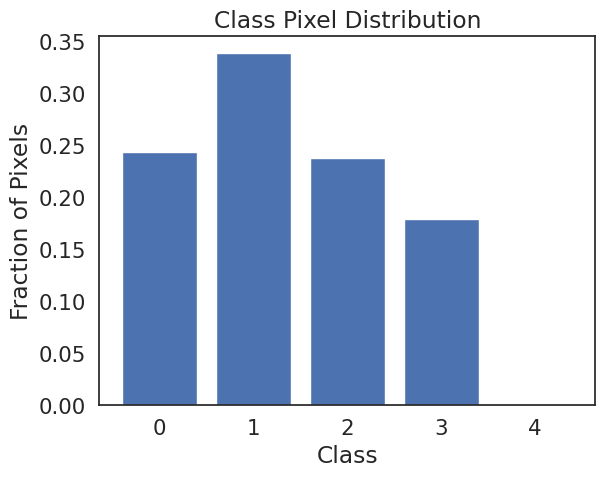

In [ ]:
from collections import Counter
import numpy as np
class_pixel_counts = Counter()

# Loop through dataset
for label_image in train_lbl:  # `label_images` is a list of 2D arrays
    unique, counts = np.unique(label_image, return_counts=True)
    class_pixel_counts.update(dict(zip(unique, counts)))

print(class_pixel_counts)  # Output: {0: 150000, 1: 5000, 2: 300000}
total_pixels = sum(class_pixel_counts.values())
class_pixel_distribution = {cls: count / total_pixels for cls, count in class_pixel_counts.items()}
print(class_pixel_distribution)  # Output: {0: 0.3, 1: 0.01, 2: 0.69}
threshold = 0.05  # Define a threshold for less-represented classes
less_represented_classes = [cls for cls, fraction in class_pixel_distribution.items() if fraction < threshold]
print(less_represented_classes)  # Output: [1]
import matplotlib.pyplot as plt

classes = list(class_pixel_distribution.keys())
fractions = list(class_pixel_distribution.values())

plt.bar(classes, fractions)
plt.xlabel("Class")
plt.ylabel("Fraction of Pixels")
plt.title("Class Pixel Distribution")
plt.show()


Visualizing examples from the training set:


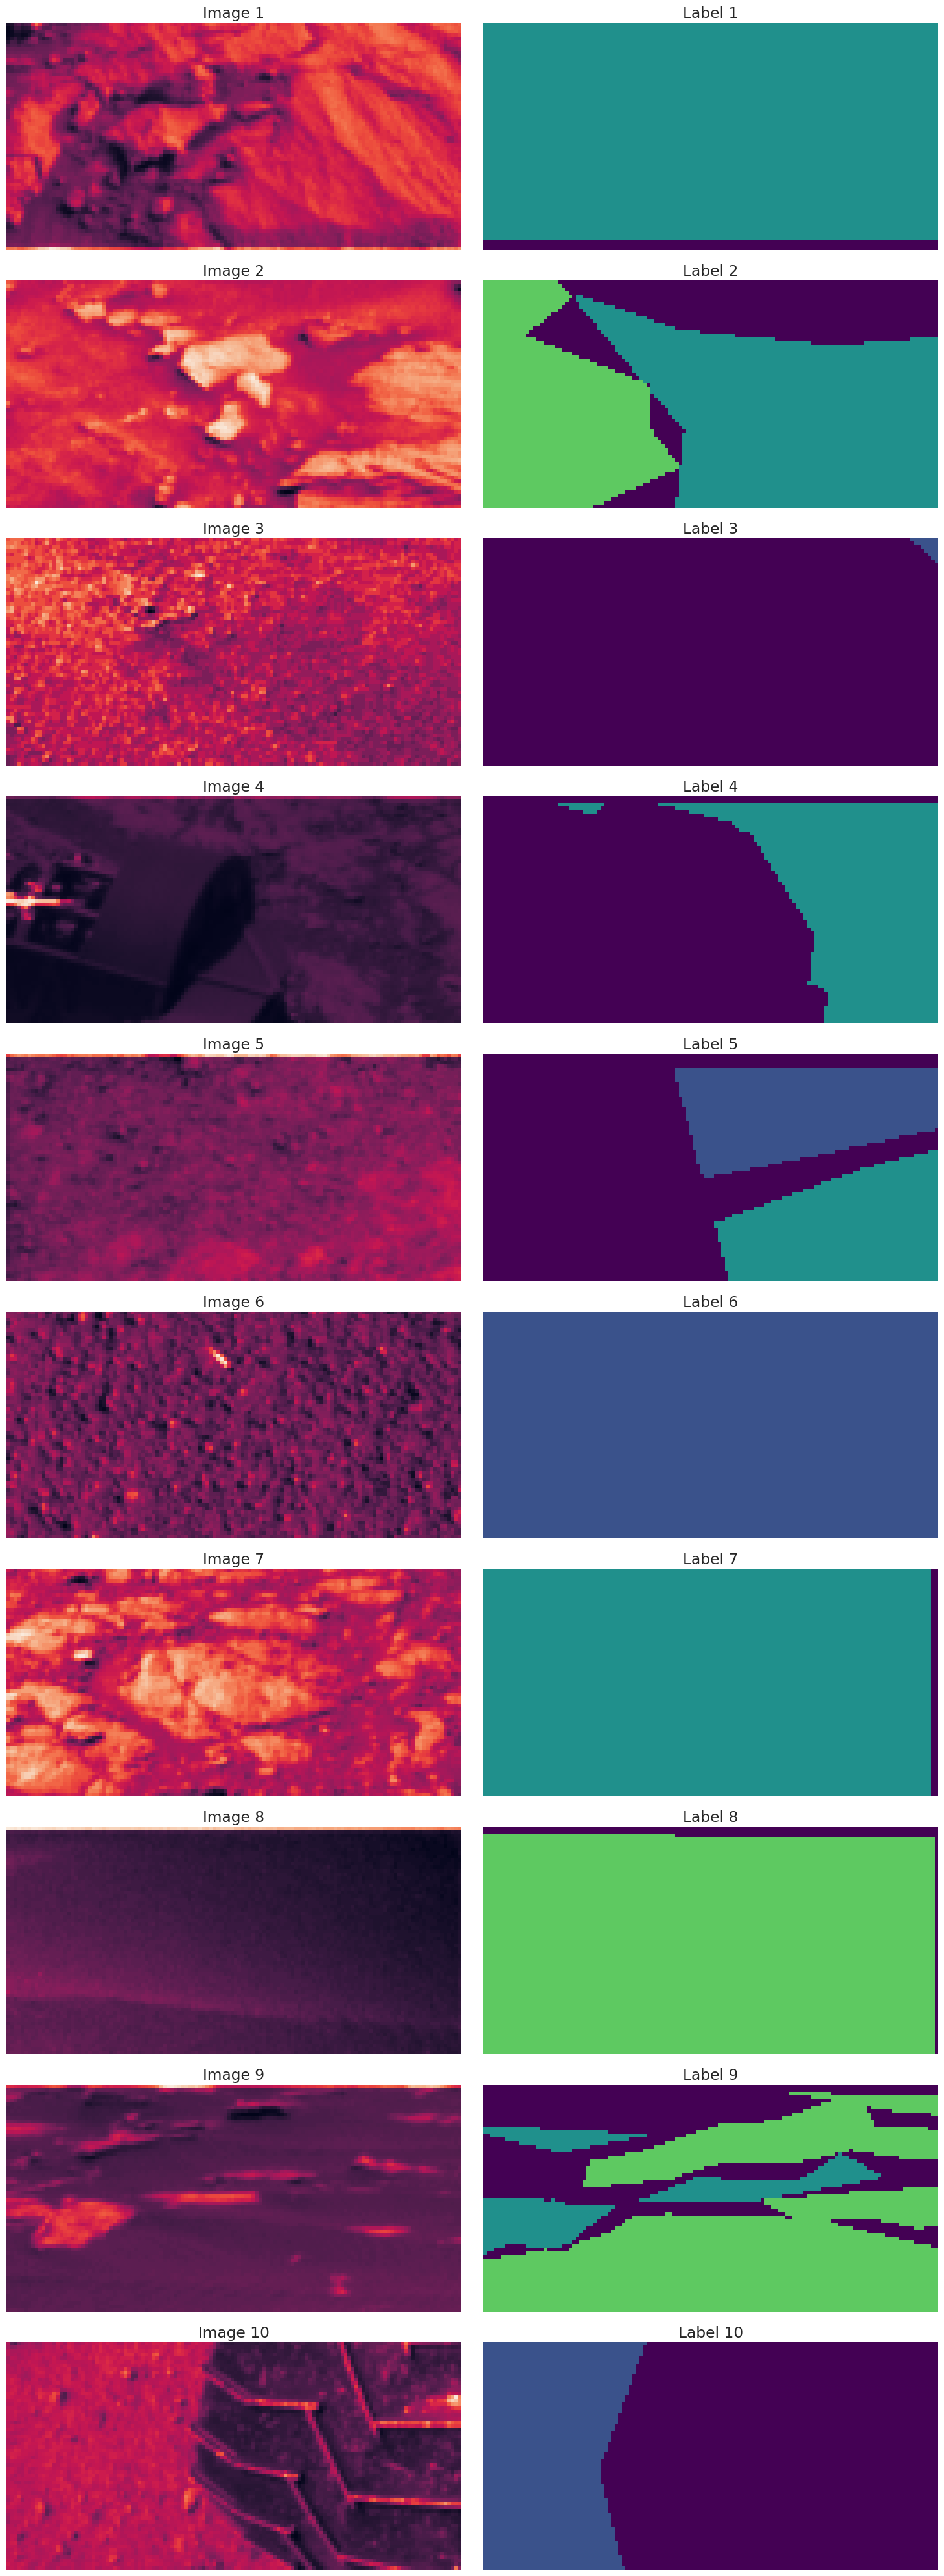

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

## 🛠️ Models and Experiments

In [ ]:

import tensorflow as tf
import tensorflow.keras.layers as tfkl

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name='', dropout_rate=0.3):
    # Initialize the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalization, Activation, and Dropout layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_regularizer=tf.keras.regularizers.l2(5e-4), kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        #x = tfkl.Dropout(dropout_rate)(x)  # Adding Dropout

    # Return the transformed tensor
    return x

def spatial_attention(x):
    # Perform a spatial attention mechanism
    # We apply average pooling followed by a convolution to learn spatial attention maps
    avg_pool = tfkl.GlobalAveragePooling2D()(x)
    avg_pool = tfkl.Reshape((1, 1, x.shape[-1]))(avg_pool)
    attention = tfkl.Conv2D(x.shape[-1], kernel_size=1, activation='sigmoid', padding='same')(avg_pool)
    return x * attention

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=42):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path, which performs a 4-time reduction of our image
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path with Spatial Attention Mechanism
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = spatial_attention(u1)  # Apply Spatial Attention here
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = spatial_attention(u2)  # Apply Spatial Attention here
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer: the final image will be a Tensor with probabilities for each class in the output
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_2        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_2[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 520,037 (1.98 MB)

 Trainable params: 518,757 (1.98 MB)

 Non-trainable params: 1,280 (5.00 KB)

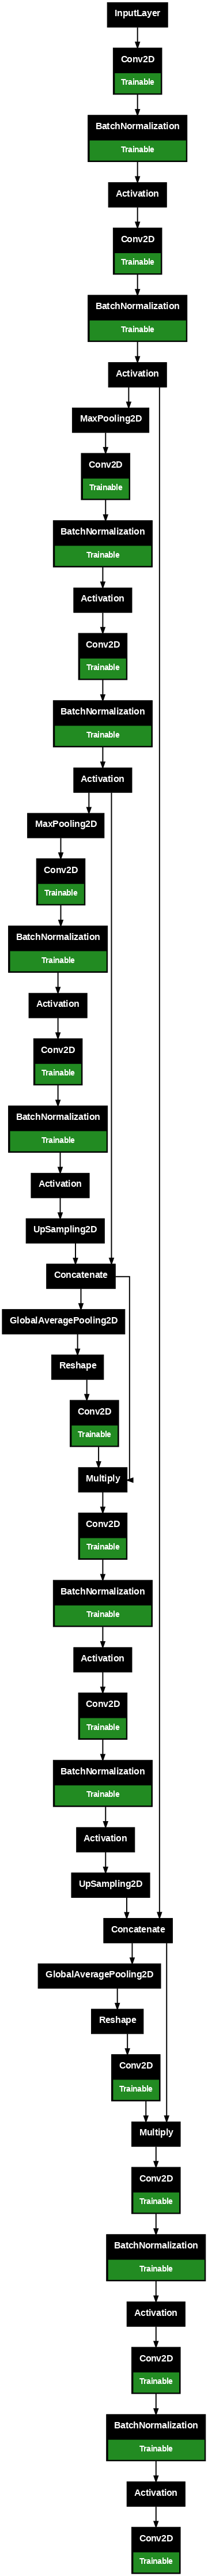

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = tf.expand_dims(self.image, 0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)  # Pass the reshaped image
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])  # Use the batch image
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:

from tensorflow.keras import backend as K

def combined_loss(gamma=4.0, alpha=0.25, num_classes=5, epsilon=1e-6, focal_weight=0.7, miou_weight=0.3):
    # Focal Loss function
    def focal_loss(y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)  # Squeeze the channel dimension
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

        # Create a mask to ignore class 0 pixels
        class_mask = tf.reduce_max(y_true_one_hot[..., 1:], axis=-1)  # Exclude class 0

        cross_entropy = -y_true_one_hot * K.log(y_pred)
        weight = alpha * y_true_one_hot * K.pow(1 - y_pred, gamma)
        focal_loss = K.sum(weight * cross_entropy, axis=-1)

        # Mask the focal loss
        focal_loss = focal_loss * class_mask

        # Normalize by the number of valid pixels
        return tf.reduce_sum(focal_loss) / tf.reduce_sum(class_mask)

    # mIoU Loss function
    def miou_loss(y_true, y_pred):
        y_true = tf.squeeze(y_true, axis=-1)  # Squeeze the channel dimension
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)  # One-hot encoding for ground truth
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())  # Ensure valid predictions

        # Create a mask to ignore class 0 pixels
        class_mask = tf.reduce_max(y_true[..., 1:], axis=-1)  # Exclude class 0

        # Compute intersection and union for each class
        intersection = K.sum(y_true * y_pred * class_mask[..., None], axis=[0, 1, 2])  # Intersection for each class
        union = K.sum(y_true * class_mask[..., None], axis=[0, 1, 2]) + K.sum(y_pred * class_mask[..., None], axis=[0, 1, 2]) - intersection  # Union for each class

        # Compute mIoU for each class
        iou = (intersection + epsilon) / (union + epsilon)

        # The final loss is the negative mean of IoU across all valid classes
        return 1 - K.mean(iou[1:])  # Exclude class 0 from mIoU calculation

    # Define the combined loss
    def loss(y_true, y_pred):
        # Calculate both losses
        focal = focal_loss(y_true, y_pred)
        miou = miou_loss(y_true, y_pred)

        # Return the weighted sum of the two losses
        return focal_weight * focal + miou_weight * miou

    return loss

In [ ]:

# Compile the model
print("Compiling model...")
model.compile(
    loss = combined_loss(gamma=4.0, alpha=0.25, num_classes=5, focal_weight=0.7, miou_weight=0.3),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[0], val_lbl[0])

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)


Epoch 1/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4700 - loss: 0.5375 - mean_iou: 0.2739

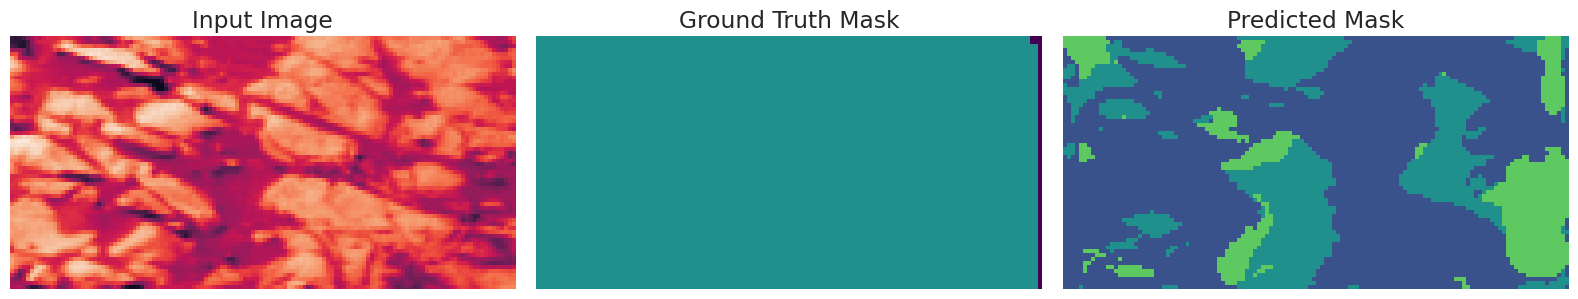

147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.4704 - loss: 0.5370 - mean_iou: 0.2742 - val_accuracy: 0.3316 - val_loss: 0.4939 - val_mean_iou: 0.1958 - learning_rate: 0.0010
Epoch 2/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5865 - loss: 0.3316 - mean_iou: 0.4797 - val_accuracy: 0.4511 - val_loss: 0.4522 - val_mean_iou: 0.2594 - learning_rate: 0.0010
Epoch 3/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6085 - loss: 0.2762 - mean_iou: 0.5120 - val_accuracy: 0.4496 - val_loss: 0.3860 - val_mean_iou: 0.3347 - learning_rate: 0.0010
Epoch 4/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6326 - loss: 0.2453 - mean_iou: 0.5573 - val_accuracy: 0.6020 - val_loss: 0.2992 - val_mean_iou: 0.4886 - learning_rate: 0.0010
Epoch 5/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6387 - loss: 0.2298 - mean_iou: 0.5741 - val_accuracy: 0.5038 - val_loss: 0.3931 - val_mean_iou: 0.4186 - learning_rate: 0.0010
Epoch 6/1000
145/147 ━━━━━━

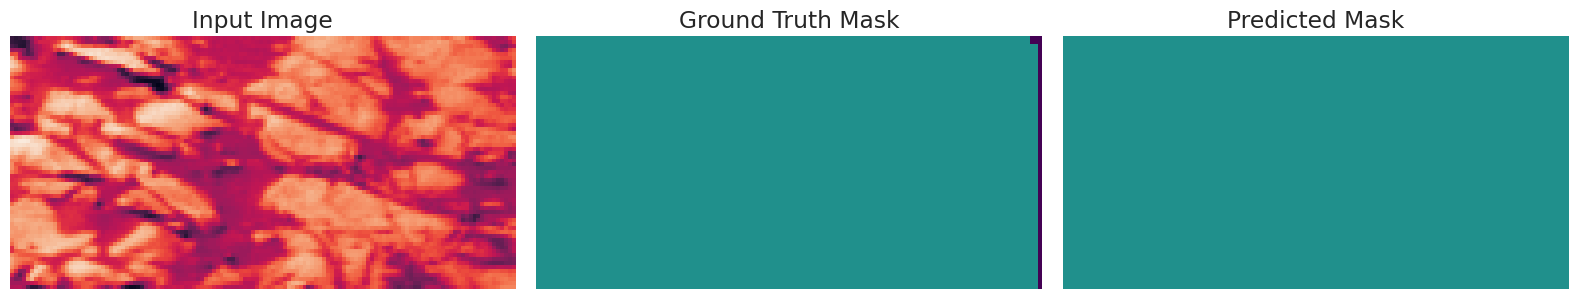

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6336 - loss: 0.2271 - mean_iou: 0.5643 - val_accuracy: 0.6358 - val_loss: 0.2461 - val_mean_iou: 0.5473 - learning_rate: 0.0010
Epoch 7/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6481 - loss: 0.2142 - mean_iou: 0.5881 - val_accuracy: 0.6327 - val_loss: 0.2213 - val_mean_iou: 0.5387 - learning_rate: 0.0010
Epoch 8/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6463 - loss: 0.2095 - mean_iou: 0.5933 - val_accuracy: 0.6169 - val_loss: 0.2465 - val_mean_iou: 0.5229 - learning_rate: 0.0010
Epoch 9/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6505 - loss: 0.2053 - mean_iou: 0.5943 - val_accuracy: 0.6158 - val_loss: 0.2279 - val_mean_iou: 0.5105 - learning_rate: 0.0010
Epoch 10/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6564 - loss: 0.1982 - mean_iou: 0.6100 - val_accuracy: 0.4888 - val_loss: 0.3155 - val_mean_iou: 0.3885 - learning_rate: 0.0010
Epoch 11/1000
145/147 ━━━━━

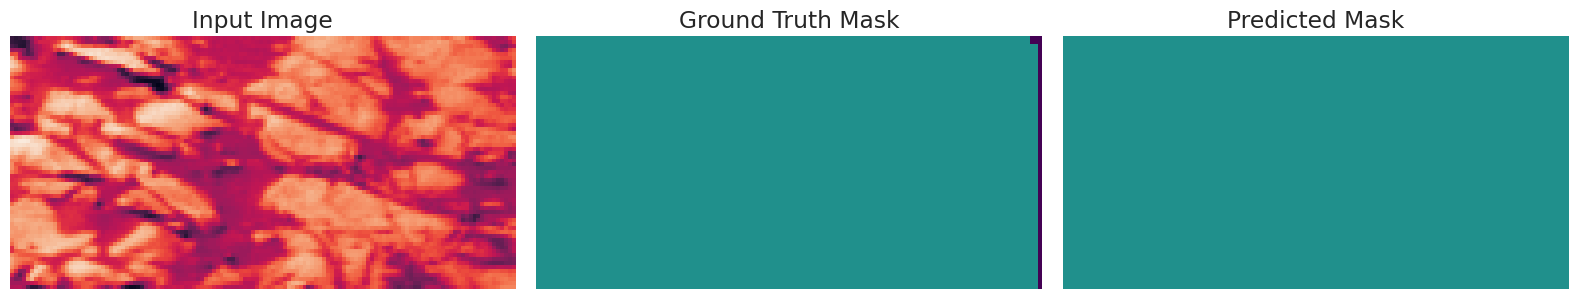

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6648 - loss: 0.1935 - mean_iou: 0.6274 - val_accuracy: 0.6135 - val_loss: 0.2300 - val_mean_iou: 0.5464 - learning_rate: 9.0484e-04
Epoch 12/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6672 - loss: 0.1862 - mean_iou: 0.6268 - val_accuracy: 0.6226 - val_loss: 0.2716 - val_mean_iou: 0.5286 - learning_rate: 8.1873e-04
Epoch 13/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6744 - loss: 0.1800 - mean_iou: 0.6476 - val_accuracy: 0.6505 - val_loss: 0.2096 - val_mean_iou: 0.5619 - learning_rate: 7.4082e-04
Epoch 14/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6787 - loss: 0.1691 - mean_iou: 0.6714 - val_accuracy: 0.6536 - val_loss: 0.2020 - val_mean_iou: 0.5785 - learning_rate: 6.7032e-04
Epoch 15/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6832 - loss: 0.1678 - mean_iou: 0.6627 - val_accuracy: 0.6678 - val_loss: 0.1982 - val_mean_iou: 0.5976 - learning_rate: 6.0653e-04
Epoc

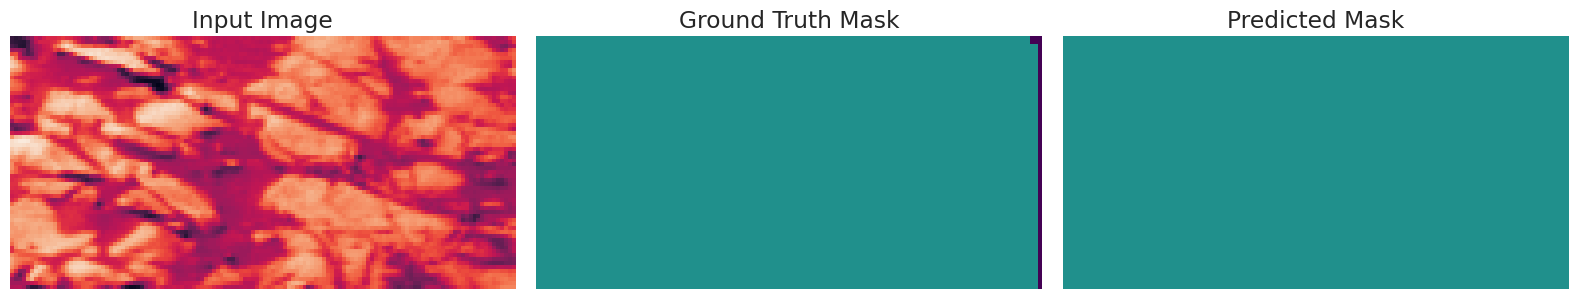

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6825 - loss: 0.1647 - mean_iou: 0.6684 - val_accuracy: 0.6359 - val_loss: 0.2155 - val_mean_iou: 0.5495 - learning_rate: 5.4881e-04
Epoch 17/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6849 - loss: 0.1636 - mean_iou: 0.6785 - val_accuracy: 0.5580 - val_loss: 0.2820 - val_mean_iou: 0.4639 - learning_rate: 4.9659e-04
Epoch 18/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6864 - loss: 0.1623 - mean_iou: 0.6807 - val_accuracy: 0.6596 - val_loss: 0.1938 - val_mean_iou: 0.6306 - learning_rate: 4.4933e-04
Epoch 19/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6974 - loss: 0.1524 - mean_iou: 0.7050 - val_accuracy: 0.6444 - val_loss: 0.2246 - val_mean_iou: 0.5555 - learning_rate: 4.0657e-04
Epoch 20/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6952 - loss: 0.1502 - mean_iou: 0.7058 - val_accuracy: 0.6773 - val_loss: 0.1806 - val_mean_iou: 0.6166 - learning_rate: 3.6788e-04
Epoc

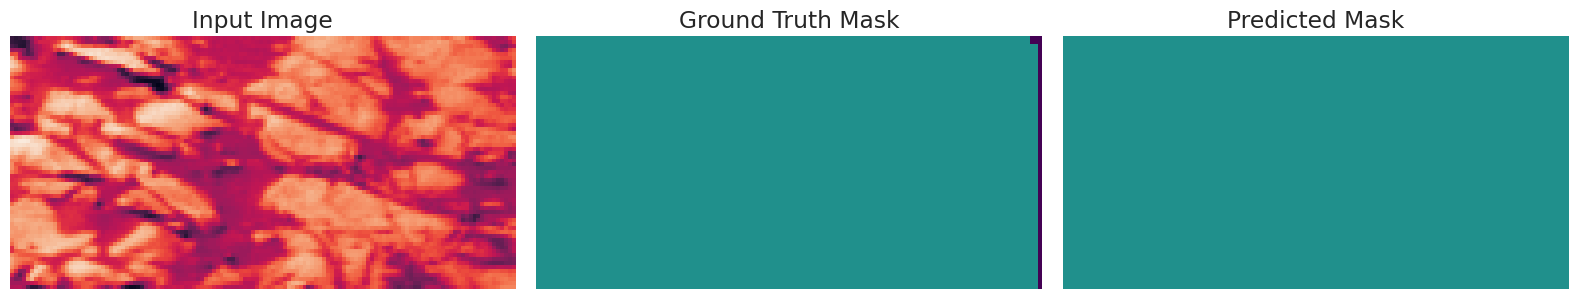

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6938 - loss: 0.1527 - mean_iou: 0.6938 - val_accuracy: 0.5062 - val_loss: 0.3254 - val_mean_iou: 0.4107 - learning_rate: 3.3287e-04
Epoch 22/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6964 - loss: 0.1507 - mean_iou: 0.7100 - val_accuracy: 0.6833 - val_loss: 0.1770 - val_mean_iou: 0.6891 - learning_rate: 3.0119e-04
Epoch 23/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7021 - loss: 0.1438 - mean_iou: 0.7172 - val_accuracy: 0.6927 - val_loss: 0.1714 - val_mean_iou: 0.6907 - learning_rate: 2.7253e-04
Epoch 24/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7037 - loss: 0.1396 - mean_iou: 0.7308 - val_accuracy: 0.6813 - val_loss: 0.1830 - val_mean_iou: 0.6651 - learning_rate: 2.4660e-04
Epoch 25/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7064 - loss: 0.1348 - mean_iou: 0.7453 - val_accuracy: 0.6995 - val_loss: 0.1657 - val_mean_iou: 0.7073 - learning_rate: 2.2313e-04
Epoc

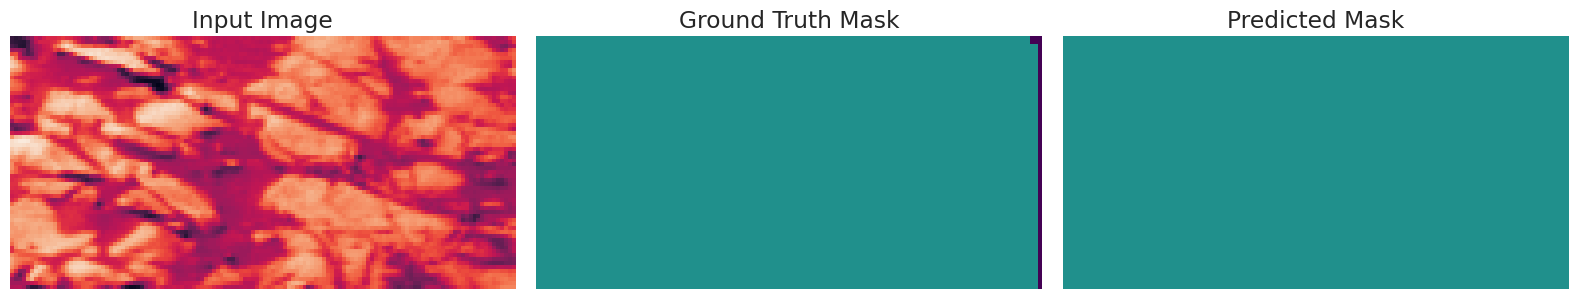

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7112 - loss: 0.1352 - mean_iou: 0.7535 - val_accuracy: 0.6854 - val_loss: 0.1725 - val_mean_iou: 0.6734 - learning_rate: 2.0190e-04
Epoch 27/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7122 - loss: 0.1319 - mean_iou: 0.7482 - val_accuracy: 0.6791 - val_loss: 0.1832 - val_mean_iou: 0.6376 - learning_rate: 1.8268e-04
Epoch 28/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7115 - loss: 0.1305 - mean_iou: 0.7608 - val_accuracy: 0.6896 - val_loss: 0.1724 - val_mean_iou: 0.6838 - learning_rate: 1.6530e-04
Epoch 29/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7199 - loss: 0.1250 - mean_iou: 0.7689 - val_accuracy: 0.6920 - val_loss: 0.1641 - val_mean_iou: 0.6733 - learning_rate: 1.4957e-04
Epoch 30/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7150 - loss: 0.1200 - mean_iou: 0.7785 - val_accuracy: 0.7008 - val_loss: 0.1605 - val_mean_iou: 0.7049 - learning_rate: 1.3534e-04
Epoc

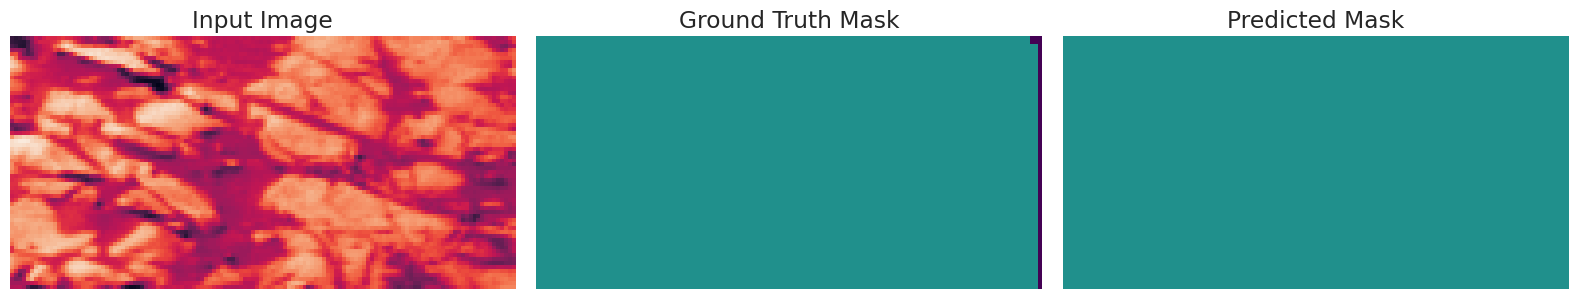

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7146 - loss: 0.1244 - mean_iou: 0.7712 - val_accuracy: 0.7064 - val_loss: 0.1555 - val_mean_iou: 0.6825 - learning_rate: 1.2246e-04
Epoch 32/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7239 - loss: 0.1137 - mean_iou: 0.8084 - val_accuracy: 0.6994 - val_loss: 0.1650 - val_mean_iou: 0.7006 - learning_rate: 1.1080e-04
Epoch 33/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7223 - loss: 0.1162 - mean_iou: 0.7919 - val_accuracy: 0.6669 - val_loss: 0.1997 - val_mean_iou: 0.6289 - learning_rate: 1.0026e-04
Epoch 34/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7228 - loss: 0.1099 - mean_iou: 0.8084 - val_accuracy: 0.6991 - val_loss: 0.1578 - val_mean_iou: 0.7120 - learning_rate: 9.0718e-05
Epoch 35/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7193 - loss: 0.1146 - mean_iou: 0.7802 - val_accuracy: 0.7026 - val_loss: 0.1544 - val_mean_iou: 0.7099 - learning_rate: 8.2085e-05
Epoc

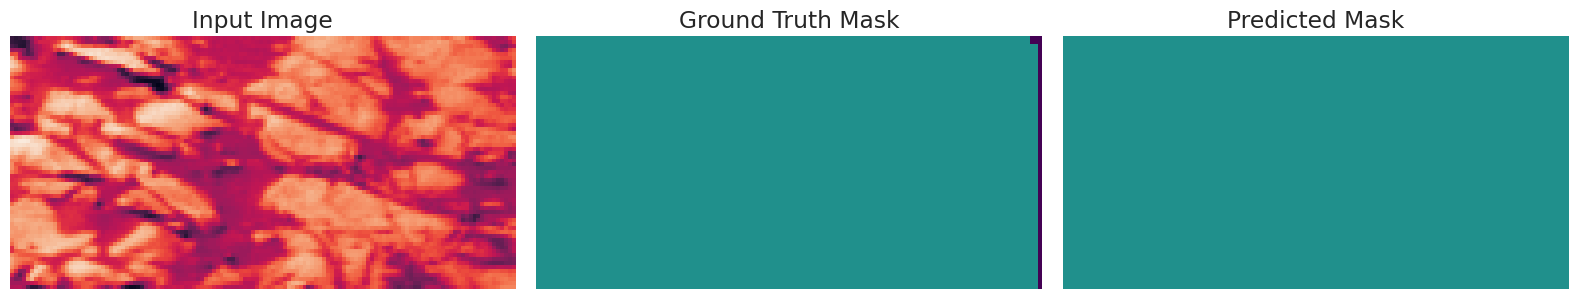

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7301 - loss: 0.1101 - mean_iou: 0.8122 - val_accuracy: 0.6967 - val_loss: 0.1704 - val_mean_iou: 0.6650 - learning_rate: 7.4273e-05
Epoch 37/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7215 - loss: 0.1068 - mean_iou: 0.8215 - val_accuracy: 0.7002 - val_loss: 0.1546 - val_mean_iou: 0.6899 - learning_rate: 6.7205e-05
Epoch 38/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7299 - loss: 0.1044 - mean_iou: 0.8246 - val_accuracy: 0.7024 - val_loss: 0.1574 - val_mean_iou: 0.6966 - learning_rate: 6.0810e-05
Epoch 39/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7305 - loss: 0.1036 - mean_iou: 0.8350 - val_accuracy: 0.7011 - val_loss: 0.1576 - val_mean_iou: 0.6883 - learning_rate: 5.5023e-05
Epoch 40/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7303 - loss: 0.0973 - mean_iou: 0.8494 - val_accuracy: 0.7003 - val_loss: 0.1592 - val_mean_iou: 0.6771 - learning_rate: 4.9787e-05
Epoc

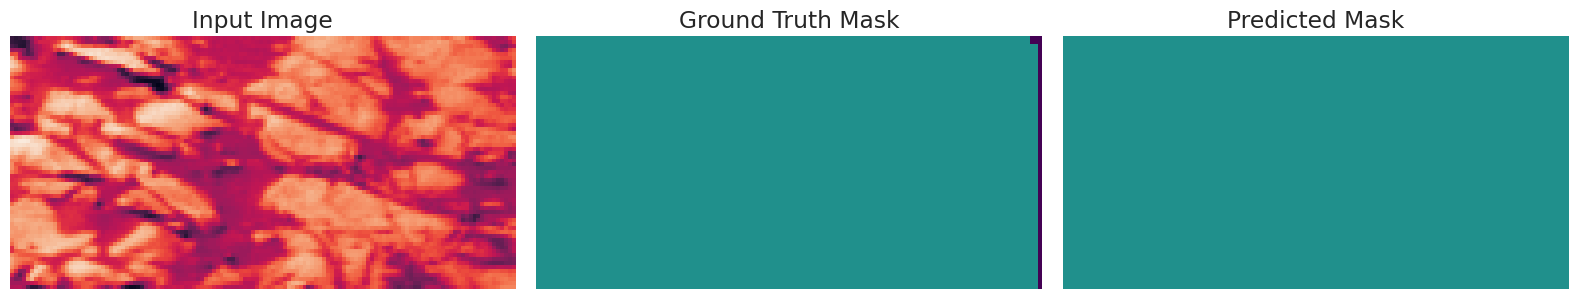

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7319 - loss: 0.0985 - mean_iou: 0.8267 - val_accuracy: 0.7077 - val_loss: 0.1521 - val_mean_iou: 0.7128 - learning_rate: 4.5049e-05
Epoch 42/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7354 - loss: 0.0937 - mean_iou: 0.8653 - val_accuracy: 0.7024 - val_loss: 0.1549 - val_mean_iou: 0.7030 - learning_rate: 4.0762e-05
Epoch 43/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7363 - loss: 0.0940 - mean_iou: 0.8614 - val_accuracy: 0.6973 - val_loss: 0.1630 - val_mean_iou: 0.6862 - learning_rate: 3.6883e-05
Epoch 44/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7346 - loss: 0.0940 - mean_iou: 0.8695 - val_accuracy: 0.6994 - val_loss: 0.1601 - val_mean_iou: 0.6910 - learning_rate: 3.3373e-05
Epoch 45/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7360 - loss: 0.0897 - mean_iou: 0.8681 - val_accuracy: 0.7054 - val_loss: 0.1530 - val_mean_iou: 0.7061 - learning_rate: 3.0197e-05
Epoc

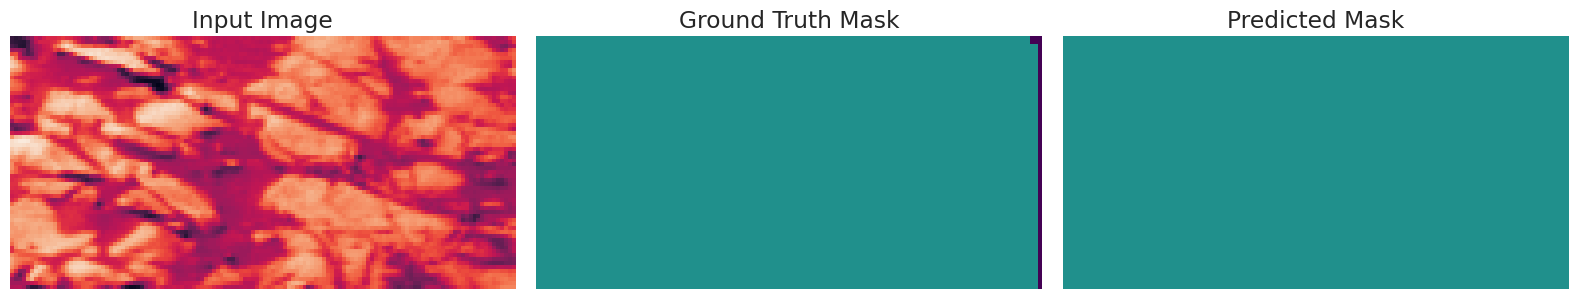

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7320 - loss: 0.0922 - mean_iou: 0.8678 - val_accuracy: 0.7079 - val_loss: 0.1531 - val_mean_iou: 0.7127 - learning_rate: 2.7324e-05
Epoch 47/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7348 - loss: 0.0936 - mean_iou: 0.8673 - val_accuracy: 0.7006 - val_loss: 0.1571 - val_mean_iou: 0.6958 - learning_rate: 2.4723e-05
Epoch 48/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7361 - loss: 0.0894 - mean_iou: 0.8673 - val_accuracy: 0.7036 - val_loss: 0.1551 - val_mean_iou: 0.7019 - learning_rate: 2.2371e-05
Epoch 49/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7368 - loss: 0.0883 - mean_iou: 0.8674 - val_accuracy: 0.7039 - val_loss: 0.1548 - val_mean_iou: 0.6932 - learning_rate: 2.0242e-05
Epoch 50/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7377 - loss: 0.0900 - mean_iou: 0.8694 - val_accuracy: 0.7055 - val_loss: 0.1547 - val_mean_iou: 0.7136 - learning_rate: 1.8316e-05
Epoc

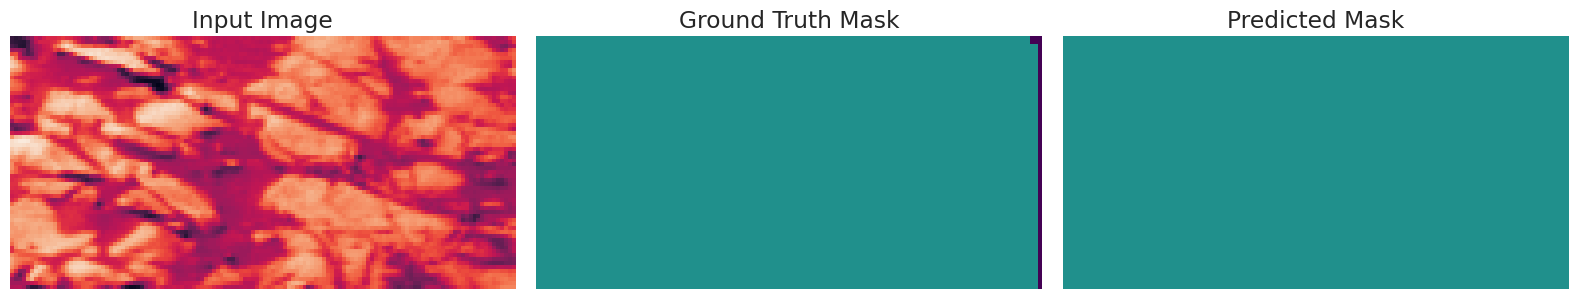

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7382 - loss: 0.0854 - mean_iou: 0.8824 - val_accuracy: 0.7034 - val_loss: 0.1548 - val_mean_iou: 0.7044 - learning_rate: 1.6573e-05
Epoch 52/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7357 - loss: 0.0873 - mean_iou: 0.8874 - val_accuracy: 0.7025 - val_loss: 0.1571 - val_mean_iou: 0.7047 - learning_rate: 1.4996e-05
Epoch 53/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7361 - loss: 0.0831 - mean_iou: 0.8874 - val_accuracy: 0.7001 - val_loss: 0.1587 - val_mean_iou: 0.6994 - learning_rate: 1.3569e-05
Epoch 54/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7372 - loss: 0.0848 - mean_iou: 0.8918 - val_accuracy: 0.7043 - val_loss: 0.1556 - val_mean_iou: 0.7072 - learning_rate: 1.2277e-05
Epoch 55/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7348 - loss: 0.0852 - mean_iou: 0.8848 - val_accuracy: 0.7033 - val_loss: 0.1550 - val_mean_iou: 0.7117 - learning_rate: 1.1109e-05
Epoc

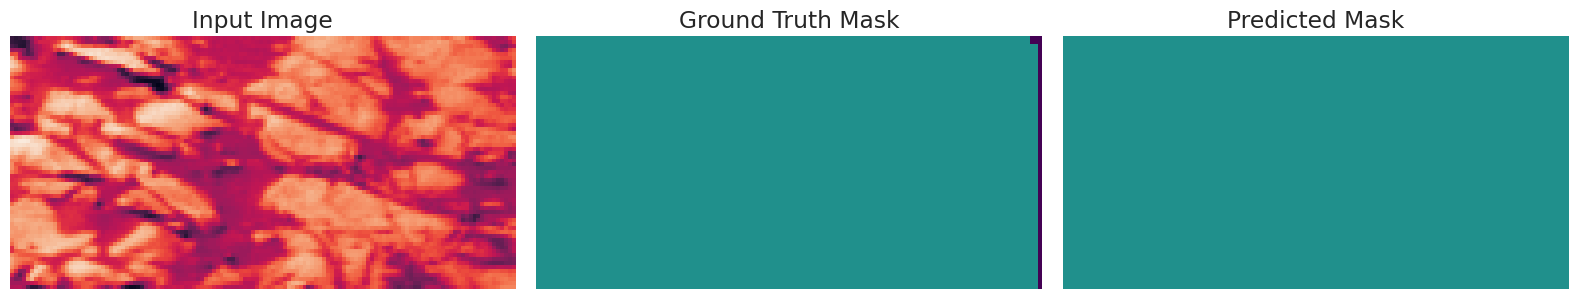

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7385 - loss: 0.0843 - mean_iou: 0.8848 - val_accuracy: 0.7030 - val_loss: 0.1563 - val_mean_iou: 0.7061 - learning_rate: 1.0052e-05
Epoch 57/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7402 - loss: 0.0811 - mean_iou: 0.8925 - val_accuracy: 0.7046 - val_loss: 0.1558 - val_mean_iou: 0.7087 - learning_rate: 9.0953e-06
Epoch 58/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7383 - loss: 0.0824 - mean_iou: 0.8910 - val_accuracy: 0.7046 - val_loss: 0.1556 - val_mean_iou: 0.7081 - learning_rate: 8.2297e-06
Epoch 59/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7383 - loss: 0.0833 - mean_iou: 0.8936 - val_accuracy: 0.7036 - val_loss: 0.1563 - val_mean_iou: 0.7065 - learning_rate: 7.4466e-06
Epoch 60/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7373 - loss: 0.0832 - mean_iou: 0.8917 - val_accuracy: 0.7045 - val_loss: 0.1559 - val_mean_iou: 0.7090 - learning_rate: 6.7379e-06
Epoc

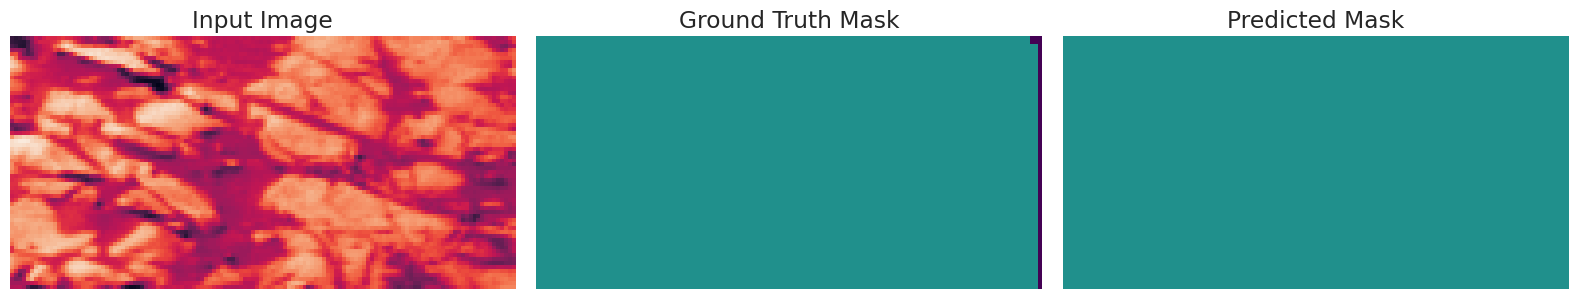

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7403 - loss: 0.0803 - mean_iou: 0.9012 - val_accuracy: 0.7040 - val_loss: 0.1560 - val_mean_iou: 0.7081 - learning_rate: 6.0967e-06
Epoch 62/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7368 - loss: 0.0801 - mean_iou: 0.8906 - val_accuracy: 0.7035 - val_loss: 0.1560 - val_mean_iou: 0.7052 - learning_rate: 5.5165e-06
Epoch 63/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7389 - loss: 0.0818 - mean_iou: 0.8954 - val_accuracy: 0.7039 - val_loss: 0.1559 - val_mean_iou: 0.7034 - learning_rate: 4.9916e-06
Epoch 64/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7384 - loss: 0.0801 - mean_iou: 0.8999 - val_accuracy: 0.7032 - val_loss: 0.1564 - val_mean_iou: 0.7030 - learning_rate: 4.5166e-06
Epoch 65/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7378 - loss: 0.0844 - mean_iou: 0.8914 - val_accuracy: 0.7045 - val_loss: 0.1566 - val_mean_iou: 0.7083 - learning_rate: 4.0868e-06
Epoc

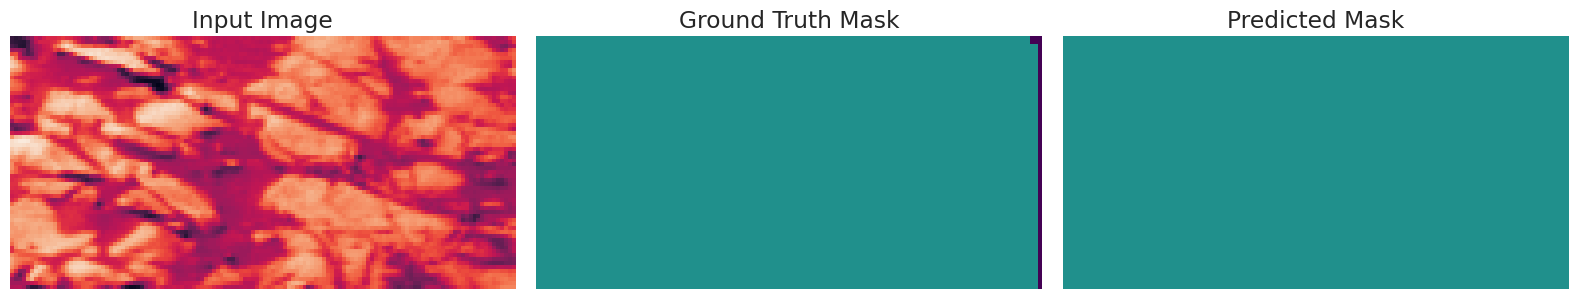

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7374 - loss: 0.0803 - mean_iou: 0.8980 - val_accuracy: 0.7041 - val_loss: 0.1573 - val_mean_iou: 0.7080 - learning_rate: 3.6979e-06
Epoch 67/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7374 - loss: 0.0819 - mean_iou: 0.8957 - val_accuracy: 0.7036 - val_loss: 0.1571 - val_mean_iou: 0.7047 - learning_rate: 3.3460e-06
Epoch 68/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7410 - loss: 0.0803 - mean_iou: 0.9034 - val_accuracy: 0.7051 - val_loss: 0.1557 - val_mean_iou: 0.7050 - learning_rate: 3.0275e-06
Epoch 69/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7400 - loss: 0.0812 - mean_iou: 0.8923 - val_accuracy: 0.7050 - val_loss: 0.1562 - val_mean_iou: 0.7074 - learning_rate: 2.7394e-06
Epoch 70/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7398 - loss: 0.0767 - mean_iou: 0.9023 - val_accuracy: 0.7043 - val_loss: 0.1566 - val_mean_iou: 0.7051 - learning_rate: 2.4787e-06
Epoc

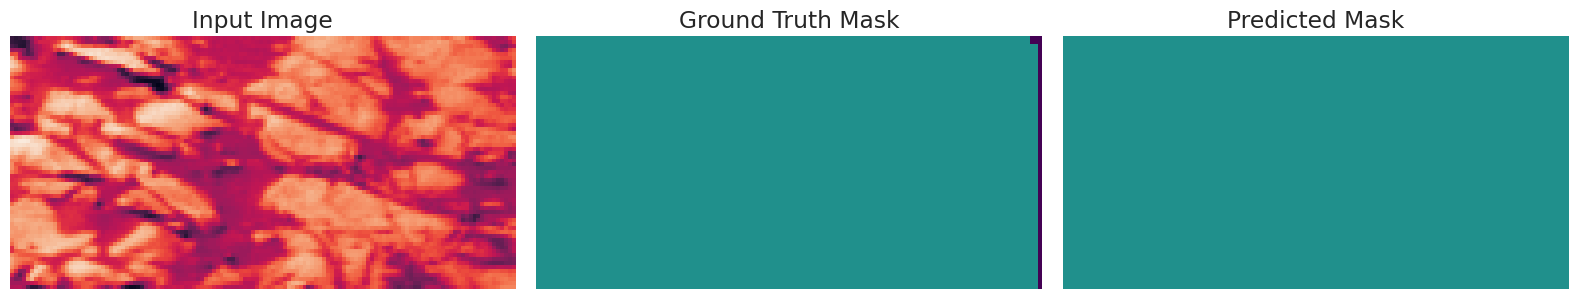

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7390 - loss: 0.0820 - mean_iou: 0.8995 - val_accuracy: 0.7036 - val_loss: 0.1568 - val_mean_iou: 0.7036 - learning_rate: 2.2429e-06
Epoch 72/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7430 - loss: 0.0827 - mean_iou: 0.8965 - val_accuracy: 0.7047 - val_loss: 0.1558 - val_mean_iou: 0.7082 - learning_rate: 2.0294e-06
Epoch 73/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7372 - loss: 0.0761 - mean_iou: 0.9003 - val_accuracy: 0.7042 - val_loss: 0.1567 - val_mean_iou: 0.7075 - learning_rate: 1.8363e-06
Epoch 74/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7385 - loss: 0.0747 - mean_iou: 0.9074 - val_accuracy: 0.7046 - val_loss: 0.1562 - val_mean_iou: 0.7077 - learning_rate: 1.6616e-06
Epoch 75/1000
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7395 - loss: 0.0804 - mean_iou: 0.8994 - val_accuracy: 0.7042 - val_loss: 0.1568 - val_mean_iou: 0.7074 - learning_rate: 1.5034e-06
Epoc

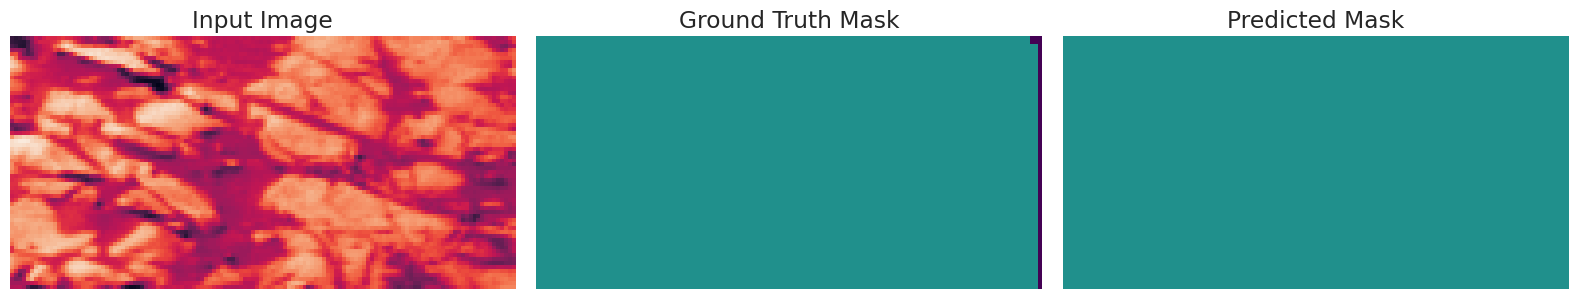

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7402 - loss: 0.0749 - mean_iou: 0.9005 - val_accuracy: 0.7044 - val_loss: 0.1569 - val_mean_iou: 0.7074 - learning_rate: 1.3604e-06
Final validation Mean Intersection Over Union: 71.36%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, lr_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')



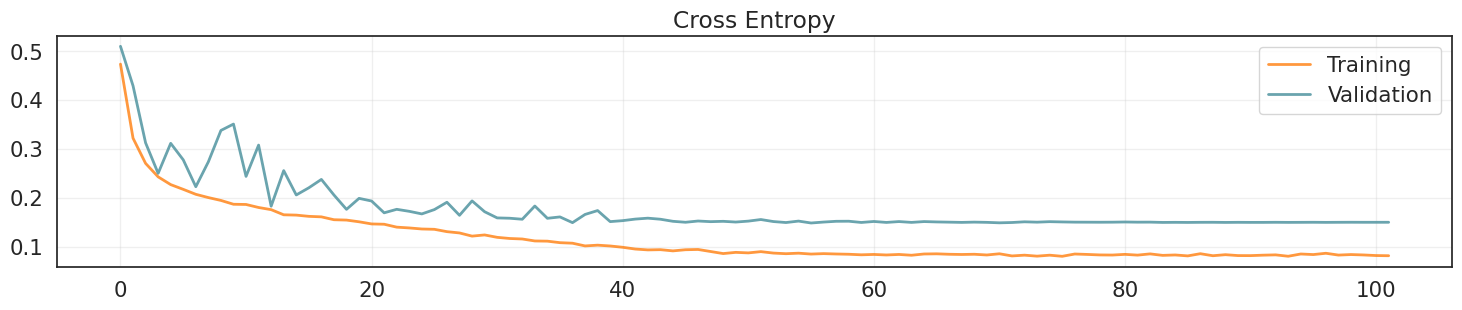

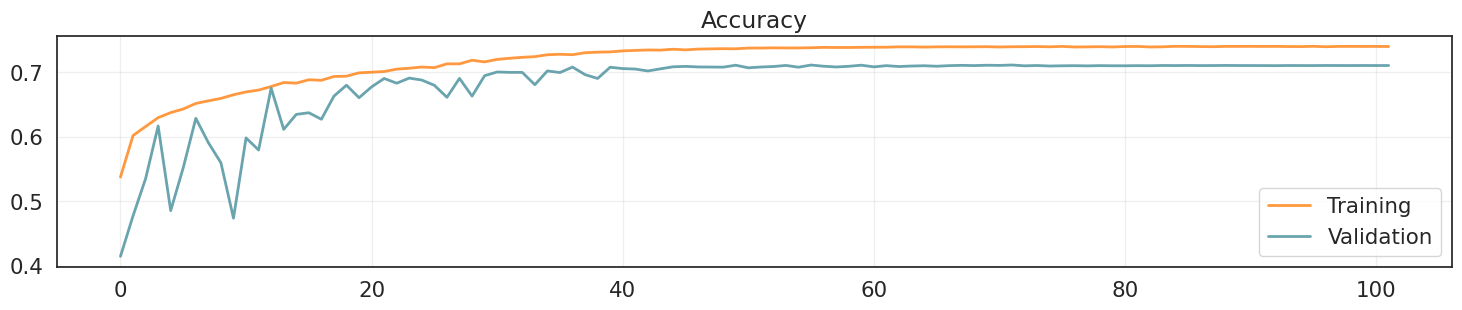

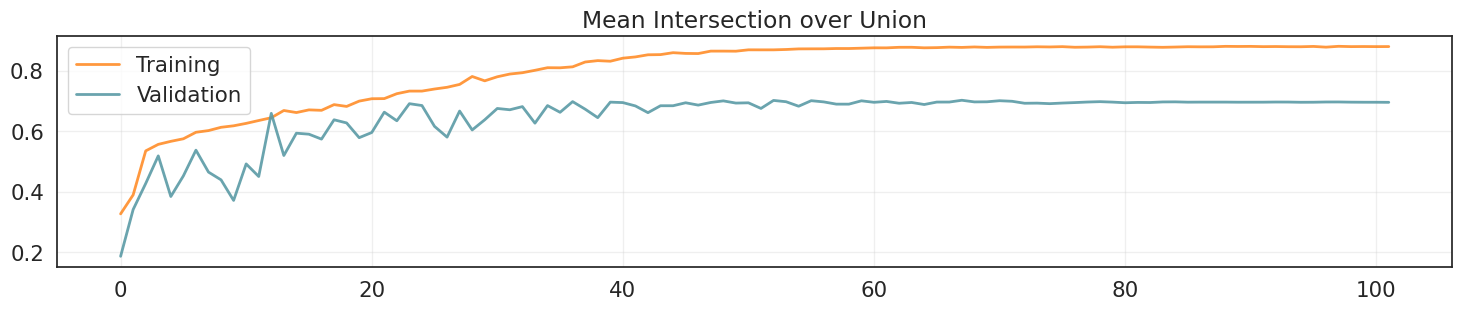

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from datetime import datetime

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
#del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_170510.keras


# Prepare Submission

In [ ]:
def flipLeftRight(images):
    flipped_images = []
    for image in images:
        flipped_image = np.fliplr(image)
        flipped_images.append(flipped_image)
    return np.array(flipped_images)

def flipUpDown(images):
    flipped_images = []
    for image in images:
        flipped_image = np.flipud(image)
        flipped_images.append(flipped_image)
    return np.array(flipped_images)

def flipUpDownLeftRight(images):
    flipped_images = []
    for image in images:
        flipped_image = np.flipud(image)
        flipped_image = np.fliplr(flipped_image)
        flipped_images.append(flipped_image)
    return np.array(flipped_images)

imagesLR = flipLeftRight(X_test)

imagesUD = flipUpDown(X_test)

imagesUDLR = flipUpDownLeftRight(X_test)

predsOriginal = model.predict(X_test)

predsLR = model.predict(imagesLR)

resPredsLR = flipLeftRight(predsLR)

predsUD = model.predict(imagesUD)

resPredsUD = flipUpDown(predsUD)

predsUDLR = model.predict(imagesUDLR)

resPredsUDLR = flipUpDownLeftRight(predsUDLR)

avgPreds = (predsOriginal + resPredsLR + resPredsUD + resPredsUDLR)*0.25

preds = np.argmax(avgPreds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Eugenio Lomurno 📧 eugenio.lomurno@polimi.it





```
   Copyright 2024 Eugenio Lomurno

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```